# Use case for "Digital twin composition via Markov Decision Processes for resilient manufacturing"

In this notebook, we present the implementation of the use cases for the paper "Digital twin composition via Markov Decision Processes for resilient manufacturing", submitted at ICSOC 2022.

## Preliminaries

### Available services

We start with the definitions of the available services.

In [15]:
# Python imports, put at the top for simplicity
from logaut import ltl2dfa
from pylogics.parsers import parse_ltl

from docs.notebooks.utils import render_mdp_dfa
from docs.notebooks.utils import render_service
from icsoc_2022.declare_utils import exactly_once, absence_2, alt_succession, alt_precedence, \
    build_declare_assumption, not_coexistence
from icsoc_2022.dfa_target import mdp_from_dfa
from icsoc_2022.services import build_service_from_transitions, Service
from icsoc_2022.constants import OTHER_ACTION_SYMBOL
from docs.notebooks.utils import render_digraph
from icsoc_2022.dfa_target import from_symbolic_automaton_to_declare_automaton


In [2]:
# default probability of being broken after an action
DEFAULT_BROKEN_PROB = 0.05

# default probability of being unemployable after the configuratoin
DEFAULT_UNEMPLOYABLE_PROB = 0.05

# default discount factor
GAMMA = 0.99

VERY_HIGH_REWARD = 3.0
HIGH_REWARD = 2.0
LOW_REWARD = 1.0
VERY_LOW_REWARD = 0.5
VERY_LOW_COST = -VERY_LOW_REWARD
LOW_COST = -LOW_REWARD
HIGH_COST = -HIGH_REWARD
VERY_HIGH_COST = -VERY_HIGH_REWARD

# default economic cost value
DEFAULT_ECONOMIC_REWARD = LOW_COST

# default quality reward value
DEFAULT_QUALITY_REWARD = LOW_REWARD

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = HIGH_COST

# default reward to repair the device
DEFAULT_REPAIR_REWARD = LOW_COST


In [3]:
# all the atomic actions for the task
BUILD_RETRIEVE_STATOR = "build_retrieve_stator"
BUILD_RETRIEVE_ROTOR = "build_retrieve_rotor"
BUILD_RETRIEVE_INVERTER = "build_retrieve_inverter"
ASSEMBLE_MOTOR = "assemble_motor"
PAINTING = "painting"
RUNNING_IN = "running_in"
ELECTRIC_TEST = "electric_test"
STATIC_TEST = "static_test"

ALL_SYMBOLS = {
    BUILD_RETRIEVE_STATOR,
    BUILD_RETRIEVE_ROTOR,
    BUILD_RETRIEVE_INVERTER,
    ASSEMBLE_MOTOR,
    PAINTING,
    RUNNING_IN,
    ELECTRIC_TEST,
    STATIC_TEST,
}

In [4]:
# service names
STATOR_BUILDER_SERVICE_NAME = "stator_builder"
ROTOR_BUILDER_SERVICE_NAME_1 = "rotor_builder_1"
ROTOR_BUILDER_SERVICE_NAME_2 = "rotor_builder_2"

We have three type of services:
- breakable machines
- warehouse machines
- human workers


In [5]:

from typing import Set


def build_generic_breakable_service(
    service_name: str,
    operation_name: str,
    economic_reward_op: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward_good: float = DEFAULT_QUALITY_REWARD,
    quality_reward_bad: float = DEFAULT_QUALITY_REWARD,
    repair_reward: float = DEFAULT_REPAIR_REWARD,
    broken_prob: float = DEFAULT_BROKEN_PROB,
    unemployable_prob: float = DEFAULT_UNEMPLOYABLE_PROB,
) -> Service:
    """Build the stator builder device."""
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    op_success_prob = 1.0 - broken_prob
    configure_success_prob = 1.0 - unemployable_prob

    # compute average quality reward
    average_quality_reward_op_action =  quality_reward_good * (1 - broken_prob) + quality_reward_bad * broken_prob

    transitions = {
        "ready": {
            f"CONFIG[{service_name}]":
                (
                    {
                        "configured": deterministic_prob
                    },
                    (0.0, 0.0)
                ),
        },
        "configured": {
          f"CHECKED[{service_name}]":
              (
                  {
                   "executing": configure_success_prob,
                   "broken": unemployable_prob},
                  (0.0, 0.0)
              ),
        },
        "executing": {
            operation_name:
                (
                    {
                        "ready": op_success_prob,
                        "broken": broken_prob
                    },
                    (economic_reward_op, average_quality_reward_op_action)
                ),
        },
        "broken": {
           f"RESTORE[{service_name}]":
               (
                   {
                       "repairing": deterministic_prob
                   },
                   (repair_reward, 0.0)
               ),
        },
        "repairing": {
          f"REPAIRED[{service_name}]":
              (
                  {
                      "ready": deterministic_prob
                  },
                  (0.0, 0.0)
              ),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore


def build_generic_service_one_state(
    operation_names: Set[str],
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the stator warehouse device."""
    transitions = {
        "ready": {
            operation_name: ({"ready": 1.0}, (economic_reward, quality_reward)) for operation_name in operation_names
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore



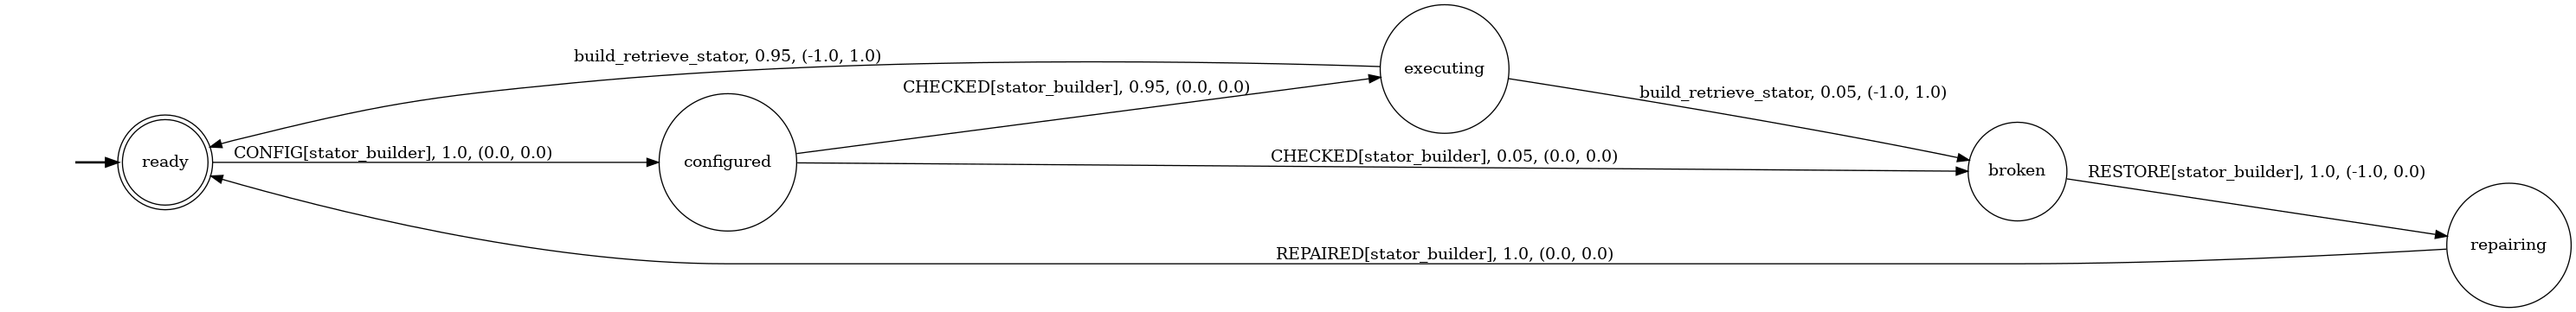

In [6]:
def stator_builder_service(
    name: str = STATOR_BUILDER_SERVICE_NAME,
    economic_reward_op: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward_good: float = DEFAULT_QUALITY_REWARD,
    quality_reward_bad: float = DEFAULT_QUALITY_REWARD,
    repair_reward: float = DEFAULT_REPAIR_REWARD,
    broken_prob: float = DEFAULT_BROKEN_PROB,
    unemployable_prob: float = DEFAULT_UNEMPLOYABLE_PROB,
) -> Service:
    """Build the stator builder device."""
    return build_generic_breakable_service(
        name,
        BUILD_RETRIEVE_STATOR,
        economic_reward_op=economic_reward_op,
        quality_reward_good=quality_reward_good,
        quality_reward_bad=quality_reward_bad,
        repair_reward=repair_reward,
        broken_prob=broken_prob,
        unemployable_prob=unemployable_prob,
    )

service_stator_builder = stator_builder_service()
render_service(service_stator_builder)

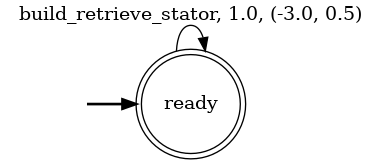

In [7]:
def stator_warehouse_service(
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the stator warehouse device."""
    return build_generic_service_one_state(
        {BUILD_RETRIEVE_STATOR},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )

service_stator_warehouse = stator_warehouse_service(economic_reward=VERY_HIGH_COST, quality_reward=VERY_LOW_REWARD)
render_service(service_stator_warehouse)

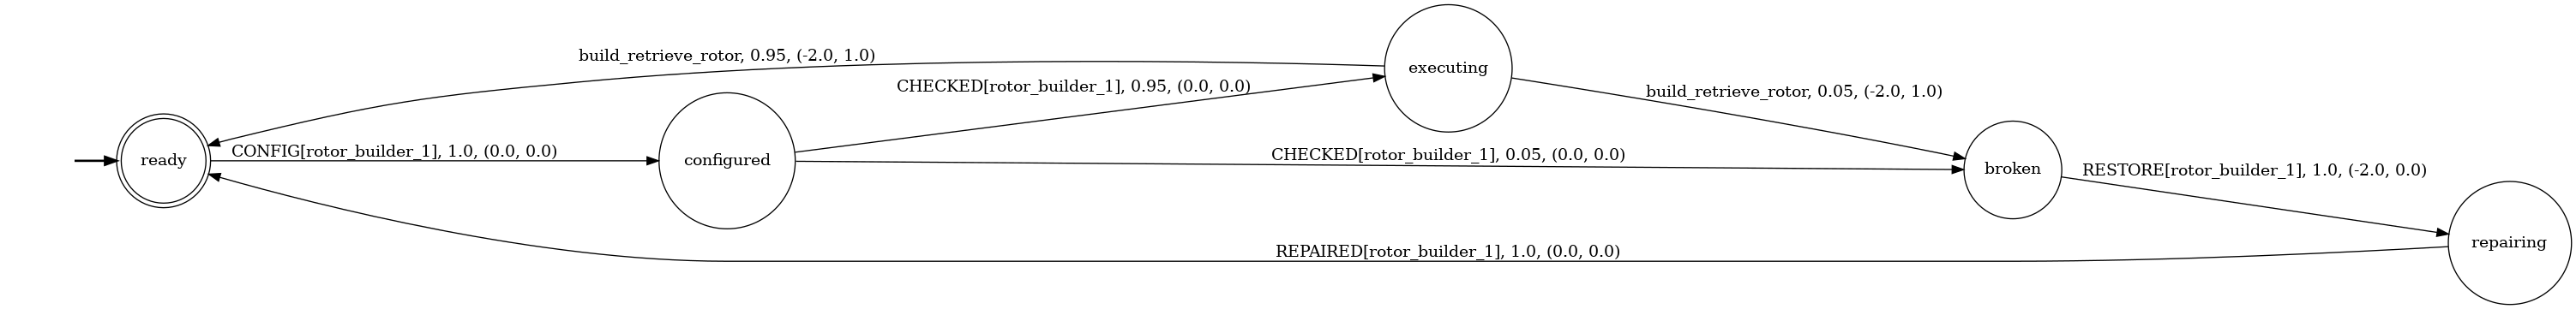

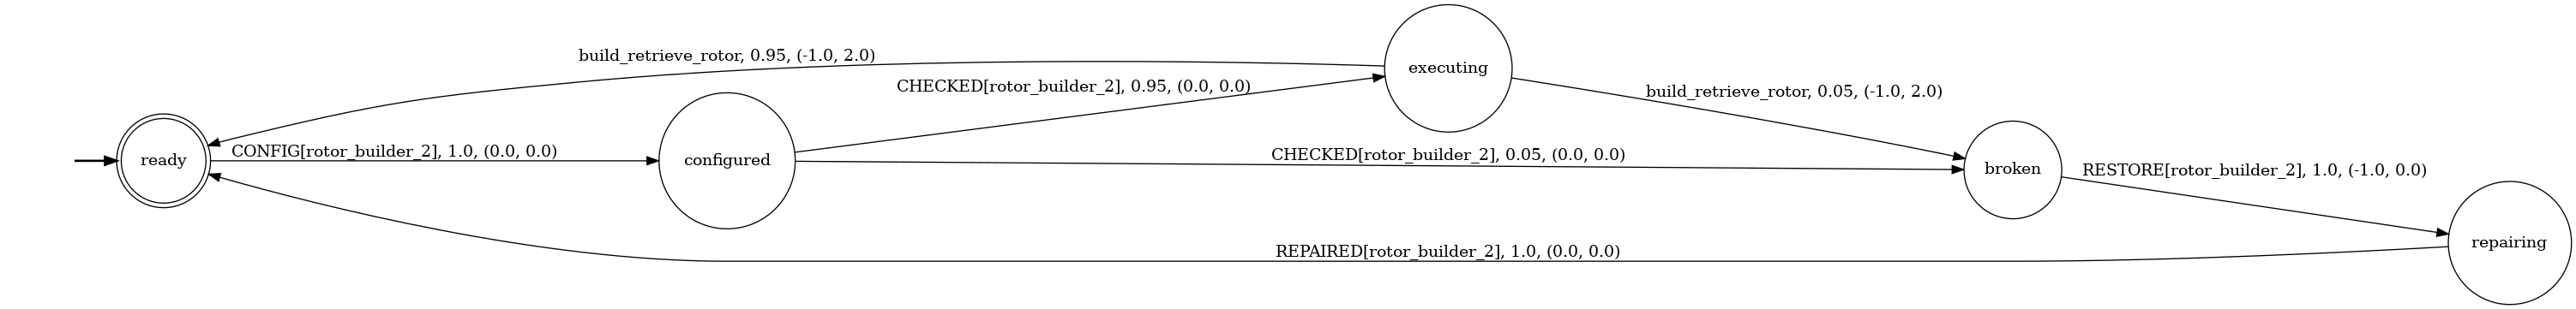

In [8]:
def rotor_builder_service(
    name: str,
    economic_reward_op: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward_good: float = DEFAULT_QUALITY_REWARD,
    quality_reward_bad: float = DEFAULT_QUALITY_REWARD,
    repair_reward: float = DEFAULT_REPAIR_REWARD,
    broken_prob: float = DEFAULT_BROKEN_PROB,
    unemployable_prob: float = DEFAULT_UNEMPLOYABLE_PROB,
) -> Service:
    """Build the rotor builder device."""
    return build_generic_breakable_service(
        name,
        BUILD_RETRIEVE_ROTOR,
        economic_reward_op=economic_reward_op,
        quality_reward_good=quality_reward_good,
        quality_reward_bad=quality_reward_bad,
        repair_reward=repair_reward,
        broken_prob=broken_prob,
        unemployable_prob=unemployable_prob,
    )

# high economic cost - low quality reward
service_rotor_builder_1 = rotor_builder_service(
    ROTOR_BUILDER_SERVICE_NAME_1,
    economic_reward_op=HIGH_COST,
    quality_reward_good=LOW_REWARD,
    quality_reward_bad=LOW_REWARD,
    repair_reward=HIGH_COST,
    broken_prob=DEFAULT_BROKEN_PROB,
    unemployable_prob=DEFAULT_UNEMPLOYABLE_PROB,
)
# low economic cost - high quality reward
service_rotor_builder_2 = rotor_builder_service(
    ROTOR_BUILDER_SERVICE_NAME_2,
    economic_reward_op=LOW_COST,
    quality_reward_good=HIGH_REWARD,
    quality_reward_bad=HIGH_REWARD,
    repair_reward=LOW_COST,
    broken_prob=DEFAULT_BROKEN_PROB,
    unemployable_prob=DEFAULT_UNEMPLOYABLE_PROB,
)

render_service(service_rotor_builder_1)
render_service(service_rotor_builder_2)

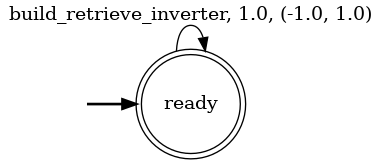

In [9]:
def inverter_warehouse_service(
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the inverter warehouse device."""
    """Build the stator warehouse device."""
    return build_generic_service_one_state(
        {BUILD_RETRIEVE_INVERTER},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )
service_inverter_warehouse = inverter_warehouse_service()
render_service(service_inverter_warehouse)

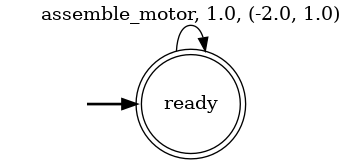

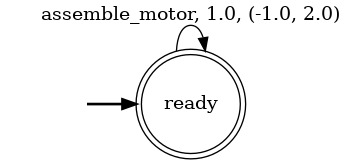

In [10]:
def assembler_service(
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the assembler device."""
    return build_generic_service_one_state(
        {ASSEMBLE_MOTOR},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )

# high economic cost - low quality reward
service_assembler_1 = assembler_service(economic_reward=HIGH_COST, quality_reward=LOW_REWARD)
# low economic cost - high quality cost
service_assembler_2 = assembler_service(economic_reward=LOW_COST, quality_reward=HIGH_REWARD)
render_service(service_assembler_1)
render_service(service_assembler_2)

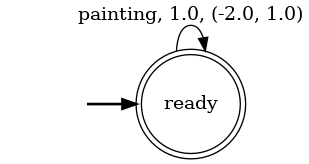

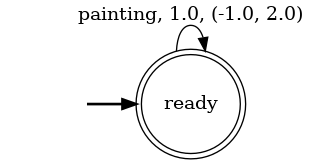

In [11]:
def painter_service(
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the painter device."""
    return build_generic_service_one_state(
        {PAINTING},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )


# high economic cost - low quality reward
service_painter_1 = painter_service(economic_reward=HIGH_COST, quality_reward=LOW_REWARD)
# low economic cost - high quality reward
service_painter_2 = painter_service(economic_reward=LOW_COST, quality_reward=HIGH_REWARD)

render_service(service_painter_1)
render_service(service_painter_2)

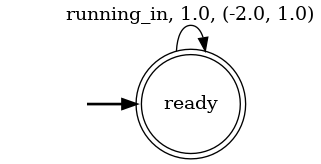

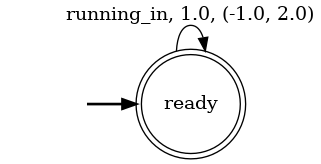

In [12]:
def smart_tester_service(
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the smart tester device."""
    return build_generic_service_one_state(
        {RUNNING_IN},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )

# high economic cost - low quality reward
service_smart_tester_1 = smart_tester_service(economic_reward=HIGH_COST, quality_reward=LOW_REWARD)
# low economic cost - high quality reward
service_smart_tester_2 = smart_tester_service(economic_reward=LOW_COST, quality_reward=HIGH_REWARD)

render_service(service_smart_tester_1)
render_service(service_smart_tester_2)

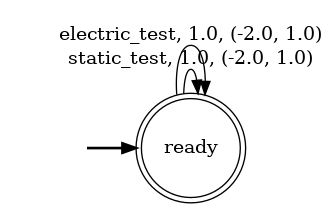

In [13]:
def mechanical_engineer_service(
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the mechanical engineer device."""
    return build_generic_service_one_state(
        {ELECTRIC_TEST, STATIC_TEST},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )

service_mechanical_engineer = mechanical_engineer_service(economic_reward=HIGH_COST, quality_reward=LOW_REWARD)
render_service(service_mechanical_engineer)

### Target specification
In this section, we list all the DECLARE constraints, transform each of them in LTLf formulas (according to the paper) and put them in conjunction in order to compute the equivalent automaton.

Then, we also show the MDP representation of the DFA.

The `other_` action captures all the actions that are not explicit in the DECLARE constraints.

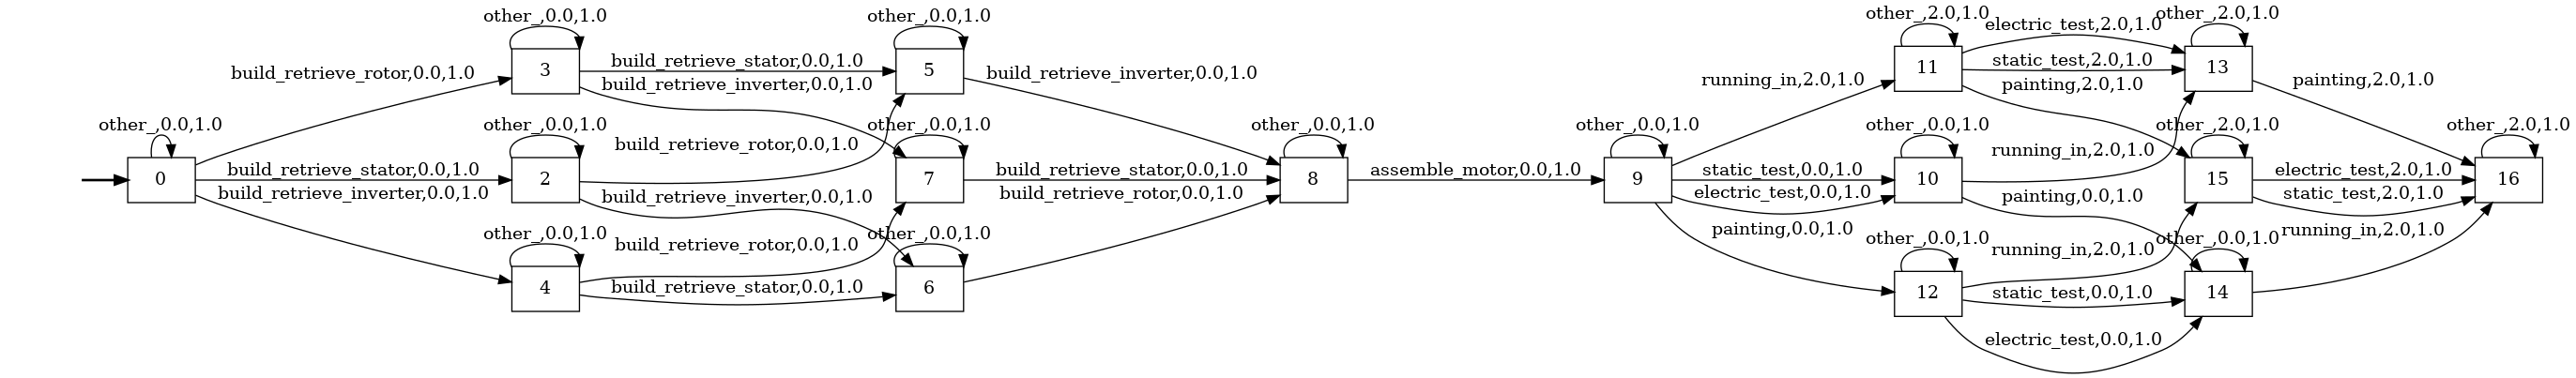

In [19]:

declare_constraints = [
    exactly_once(BUILD_RETRIEVE_STATOR),
    exactly_once(BUILD_RETRIEVE_ROTOR),
    exactly_once(BUILD_RETRIEVE_INVERTER),
    exactly_once(RUNNING_IN),
    exactly_once(ASSEMBLE_MOTOR),
    absence_2(ELECTRIC_TEST),
    absence_2(PAINTING),
    absence_2(STATIC_TEST),
    alt_succession(BUILD_RETRIEVE_STATOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_ROTOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_INVERTER, ASSEMBLE_MOTOR),
    alt_succession(ASSEMBLE_MOTOR, RUNNING_IN),
    alt_precedence(ASSEMBLE_MOTOR, PAINTING),
    alt_precedence(ASSEMBLE_MOTOR, ELECTRIC_TEST),
    alt_precedence(ASSEMBLE_MOTOR, STATIC_TEST),
    not_coexistence(ELECTRIC_TEST, STATIC_TEST),
    build_declare_assumption(ALL_SYMBOLS.union({OTHER_ACTION_SYMBOL})),
]
formula_str = " & ".join(map(lambda s: f"({s})", declare_constraints))
formula = parse_ltl(formula_str)
automaton = ltl2dfa(formula, backend="lydia")
declare_automaton = from_symbolic_automaton_to_declare_automaton(automaton, ALL_SYMBOLS.union({OTHER_ACTION_SYMBOL}))
target_mdp = mdp_from_dfa(declare_automaton, gamma=GAMMA)
render_mdp_dfa(target_mdp, simplified=True)